In [1]:
## Import Python libraries ## 

import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import xarray as xr


%matplotlib inline
%reload_ext xsimlab.ipython


import fastscape

from orographic_precipitation.fastscape_ext import precip_model
from fastscape.processes import Bedrock

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


In [3]:
## Build xarray-simlab model ##
SouthernAndesLEM = precip_model
SouthernAndesLEM = precip_model.drop_processes(['init_topography'])
SouthernAndesLEM = SouthernAndesLEM.update_processes({'bedrock': Bedrock})

SouthernAndesLEM

<xsimlab.Model (17 processes, 26 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
surf2erode
diffusion
    diffusivity            [in] () or ('y', 'x') diffusivity (trans...
init_erosion
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] () or ('y', 'x') background, non-or...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time    

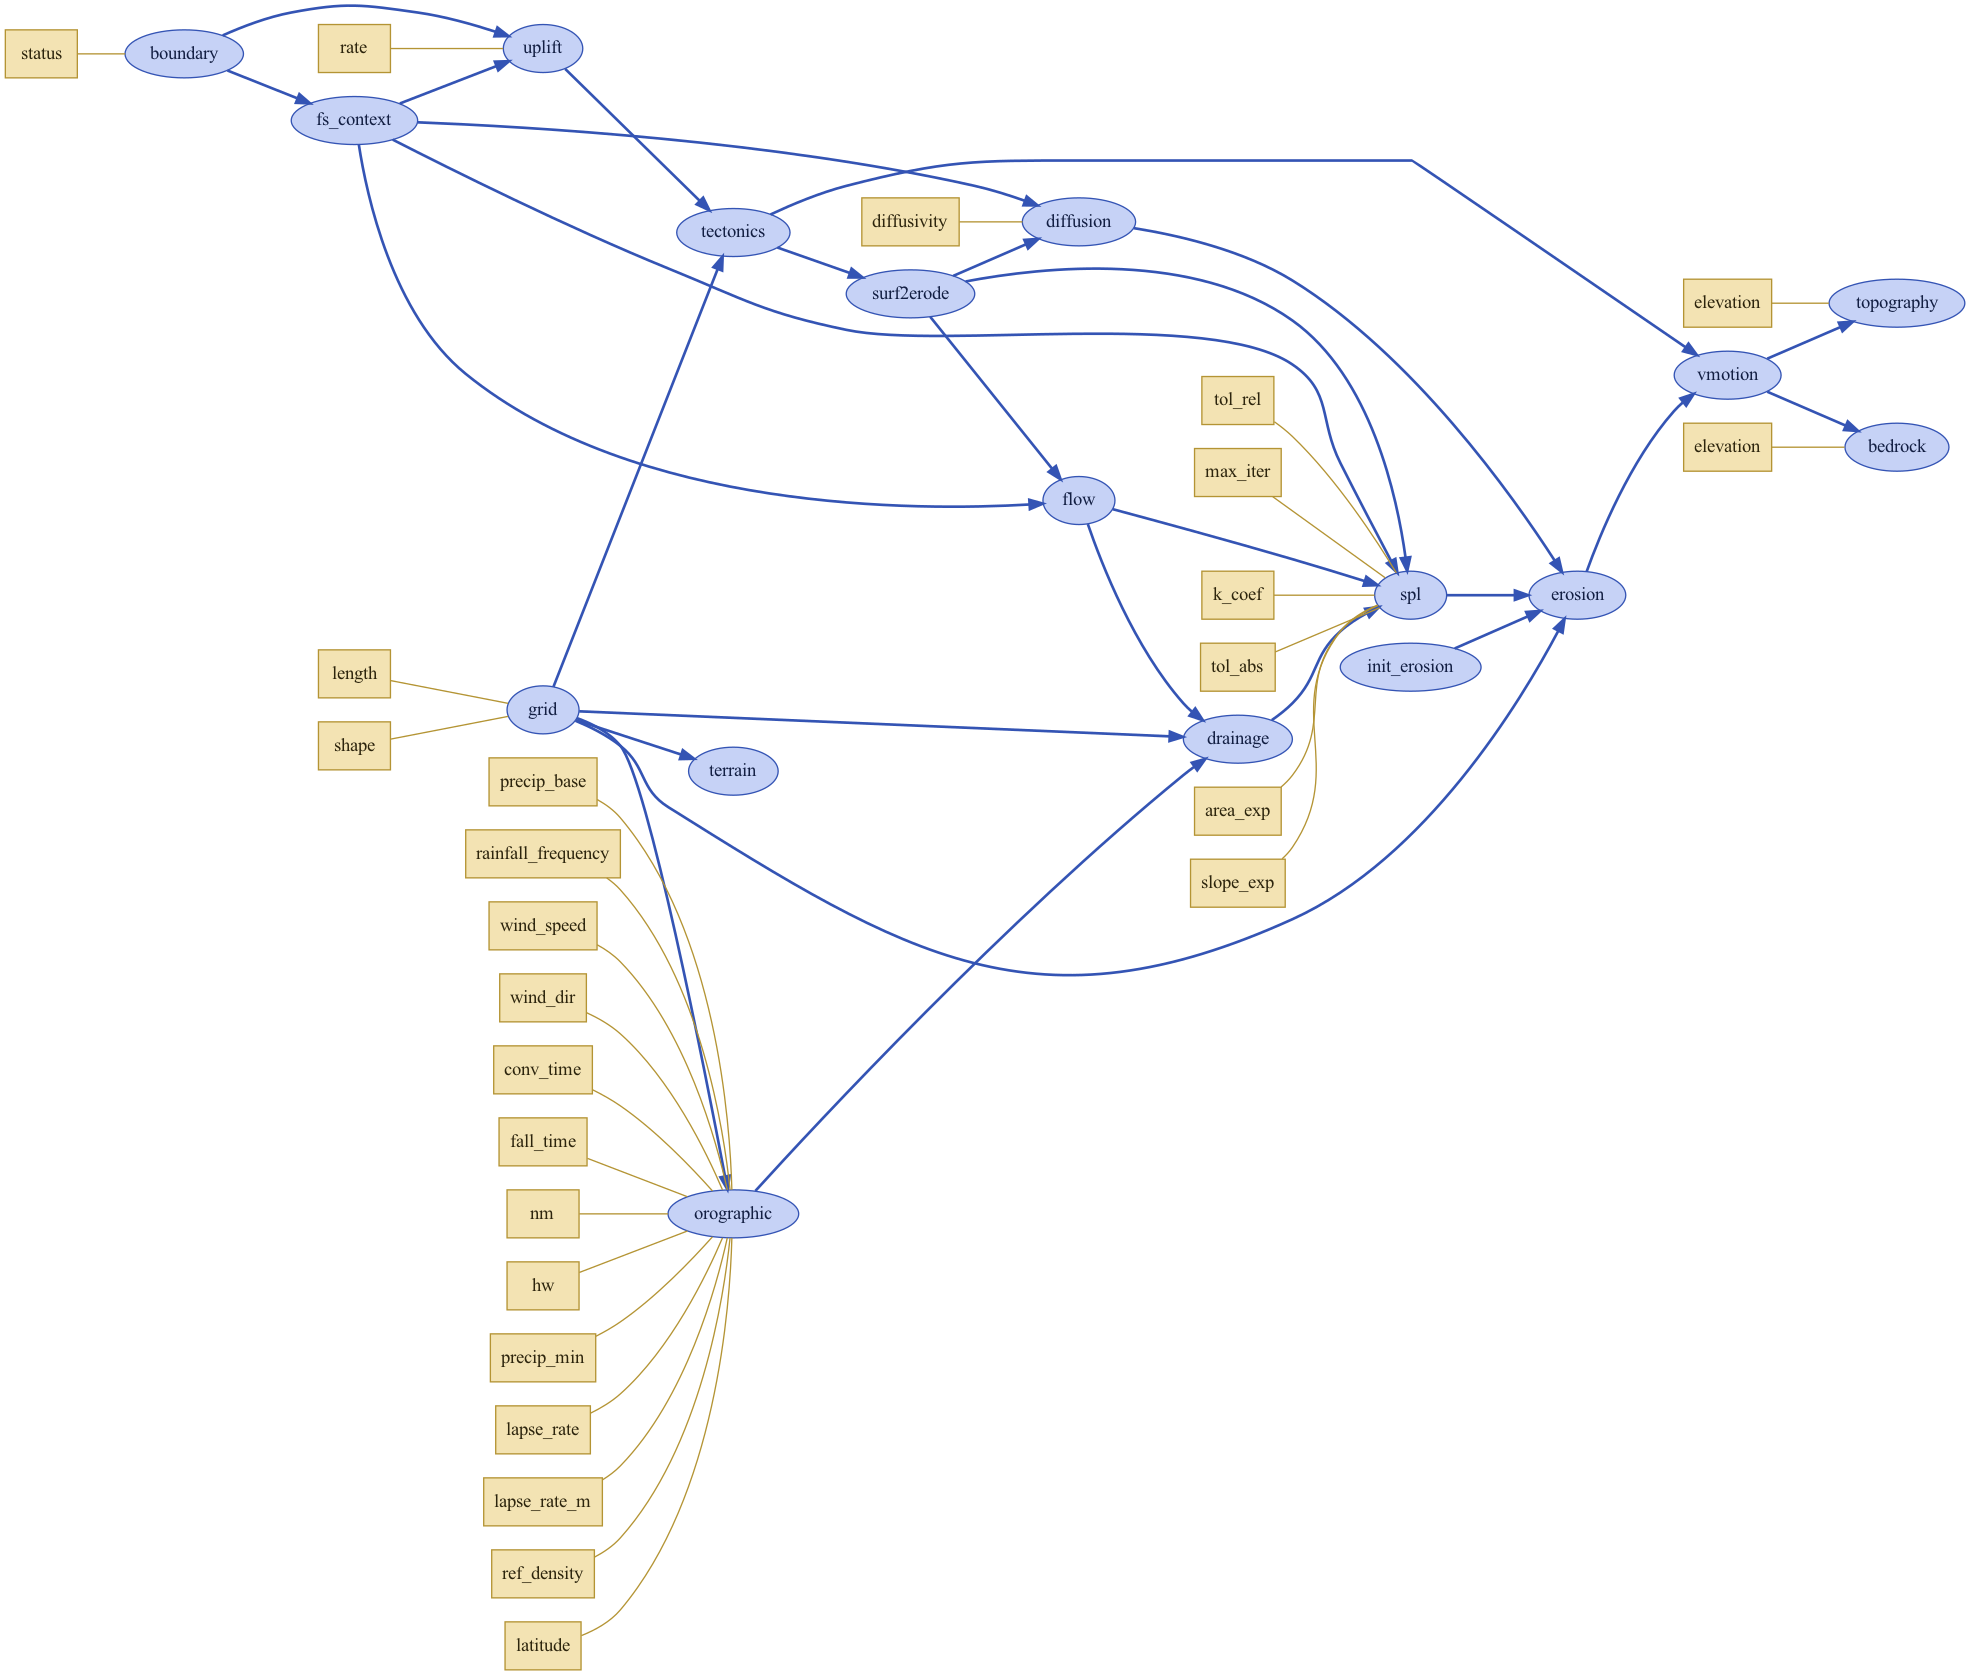

In [4]:
## Visualise xarray-simlab ##
SouthernAndesLEM.visualize(show_inputs='True')

In [5]:
## Model dimensions/grid dimensions ##
nx = 100
ny = 100
nn = nx * ny

xl = 100.e3
yl = 100.e3

BoundaryCondition = ['looped', 'looped', 'fixed_value', 'fixed_value']

## Model time and time stepping ##
EndTime_1 = 5e6
EndTime_2 = 5e6
EndTime_3 = 8e6
TimeSteps_1 = 10001
TimeSteps_2 = 10001
TimeSteps_3 = 16001

# EndTime = 1e6
# TimeSteps = 1001
ModelTime_1 = np.linspace(0., EndTime_1, TimeSteps_1)
ModelTime_2 = np.linspace(0., EndTime_2, TimeSteps_2)
ModelTime_3 = np.linspace(0., EndTime_3, TimeSteps_3)

PlotStep = 100

## Tectonics ##
k_coef= 2.5e-5
area_exp = 0.4
slope_exp = 1.0
diffusion_diffusivity = 0.


## Orographic ##
lapse_rate = -5.4 #mean lapse rate of area not too far away 
lapse_rate_m = -6.5 #left default
ref_density = 7.4e-3  #left default
rainfall_frequency = 5 #could not find high resolution data for hourly rainfall in the area of patagonia i was interested in looking at so just and estimate
latitude = 46  #latitude around the area north in the Patagonian Andes
precip_base =  1e-4 #not sure if I should change this or not
wind_speed = 10 #base to start with 
wind_dir = 270  # estimated direction given weather info 
precip_min = 0.1 #default
conv_time = 2000 #2000 thesis value
fall_time = 2000 #2000 thesis value
nm = 0.003  #0.03 #thesis value
hw = 5000  #deafault


## Initial topography ##
WhiteNoiseLevel = 50 # in [m], amplitude of noise

## Seed for Reproducibility ##
RandomSeed = 1410

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid size
nx, ny = 100, 100  # Example values; adjust as needed
nn = nx * ny  # Total number of nodes

# Initialize an array to store elevations
InitialTopography = np.zeros(nn)

# Assign elevations based on node indices (using slicing and grid structure)
InitialTopography[:int(0.25 * nn)] = 400    # First 25% of nodes
InitialTopography[int(0.25 * nn):int(0.5 * nn)] = 3375  # Next 25% of nodes
InitialTopography[int(0.5 * nn):int(0.75 * nn)] = 2500  # Next 25% of nodes
InitialTopography[int(0.75 * nn):] = 1000  # Last 25% of nodes

# Adding random noise to the elevations
np.random.seed(42)  # For reproducibility
WhiteNoiseLevel = 50  # Standard deviation of noise
Noise = np.random.normal(0, WhiteNoiseLevel, nn)
InitialTopography += Noise  # Add noise to the elevations

# Reshape the 1D array to 2D with shape (ny, nx)
InitialTopography_2D = InitialTopography.reshape((ny, nx))

# Define first stage uplift rates for each region
UpliftRates = np.zeros(nn)  # Initialize uplift rates array

# Assign uplift rates to regions (using slicing or fractions of the total nodes)
UpliftRates[:int(0.25 * nn)] = 0.01    # First 25% of nodes
UpliftRates[int(0.25 * nn):int(0.5 * nn)] = 0.041  # Next 25% of nodes
UpliftRates[int(0.5 * nn):int(0.75 * nn)] = 0.035  # Next 25% of nodes
UpliftRates[int(0.75 * nn):] = 0.02  # Last 25% of nodes

# Adding random noise to the uplift rates for realism (optional)
np.random.seed(42)  # For reproducibility
UpliftNoise = np.random.normal(0, 0.005, nn)  # Small noise in uplift rates
UpliftRates += UpliftNoise  # Add noise to the uplift rates

# Reshape the 1D array to 2D with shape (ny, nx)
UpliftRates_2D = UpliftRates.reshape((ny, nx))

# Rotate both topography and uplift rates 90 degrees anti-clockwise
RotatedTopography_2D = np.rot90(InitialTopography_2D, k=1)
RotatedUpliftRates_2D = np.rot90(UpliftRates_2D, k=1)

In [7]:
import os
import numpy as np
import xsimlab as xs

# Directory to save Zarr files
output_dir = "simulation_outputs"
os.makedirs(output_dir, exist_ok=True)

# Define rainfall_frequency values to test
rainfall_frequency_values = np.linspace(0.1, 12, 10)  # Example range from 0.1 to 2.0

# Time steps to visualize
time_indices = [0, 1, 10, 100, 1000, 10000]
mean_elevations = []

# Loop through rainfall_frequency values and run simulations
for rainfall_frequency in rainfall_frequency_values:
    print(f"Running simulation for rainfall_frequency = {rainfall_frequency}")
    
    # Set up the model with the current rainfall_frequency
    in_ds_rain = xs.create_setup(
        model=SouthernAndesLEM,
        clocks={
            'time': ModelTime_1,
            'output': ModelTime_1[::PlotStep]
        },
        master_clock='time',
        input_vars={
            'grid': {'shape': [nx, ny], 'length': [xl, yl]},
            'boundary': {'status': BoundaryCondition},
            'topography': {'elevation': RotatedTopography_2D},
            'bedrock': {'elevation': RotatedTopography_2D},
            'uplift': {'rate': RotatedUpliftRates_2D},
            'spl': {'k_coef': k_coef, 'area_exp': area_exp, 'slope_exp': slope_exp},
            'diffusion': {'diffusivity': diffusion_diffusivity},
            'orographic': {
                'lapse_rate': lapse_rate,
                'lapse_rate_m': lapse_rate_m,
                'ref_density': ref_density,
                'rainfall_frequency': rainfall_frequency,  # Change rainfall_frequency
                'latitude': latitude,
                'precip_base': precip_base,
                'wind_speed': wind_speed,
                'wind_dir': wind_dir,
                'precip_min': precip_min,
                'conv_time': conv_time,
                'fall_time': fall_time,
                'nm': nm,
                'hw': hw,
            },
        },
        output_vars={'topography__elevation': 'time', 'orographic__precip_rate': 'time'}
    )

    # Run the simulation
    with xs.monitoring.ProgressBar():
        out_ds_rain = in_ds_rain.xsimlab.run(model=SouthernAndesLEM)
    
    # Store simulation results in Zarr format
    zarr_filename = os.path.join(output_dir, f"simulation_rainfall_frequency_{rainfall_frequency:.2f}.zarr")
    out_ds_rain.to_zarr(zarr_filename, mode='w')
    print(f"Saved results for rainfall_frequency = {rainfall_frequency} to {zarr_filename}")


Running simulation for rainfall_frequency = 0.1


             0% | initialize 

Saved results for rainfall_frequency = 0.1 to simulation_outputs/simulation_rainfall_frequency_0.10.zarr
Running simulation for rainfall_frequency = 1.4222222222222223


             0% | initialize 

Saved results for rainfall_frequency = 1.4222222222222223 to simulation_outputs/simulation_rainfall_frequency_1.42.zarr
Running simulation for rainfall_frequency = 2.7444444444444445


             0% | initialize 

Saved results for rainfall_frequency = 2.7444444444444445 to simulation_outputs/simulation_rainfall_frequency_2.74.zarr
Running simulation for rainfall_frequency = 4.066666666666666


             0% | initialize 

Saved results for rainfall_frequency = 4.066666666666666 to simulation_outputs/simulation_rainfall_frequency_4.07.zarr
Running simulation for rainfall_frequency = 5.388888888888888


             0% | initialize 

Saved results for rainfall_frequency = 5.388888888888888 to simulation_outputs/simulation_rainfall_frequency_5.39.zarr
Running simulation for rainfall_frequency = 6.71111111111111


             0% | initialize 

Saved results for rainfall_frequency = 6.71111111111111 to simulation_outputs/simulation_rainfall_frequency_6.71.zarr
Running simulation for rainfall_frequency = 8.033333333333333


             0% | initialize 

Saved results for rainfall_frequency = 8.033333333333333 to simulation_outputs/simulation_rainfall_frequency_8.03.zarr
Running simulation for rainfall_frequency = 9.355555555555554


             0% | initialize 

Saved results for rainfall_frequency = 9.355555555555554 to simulation_outputs/simulation_rainfall_frequency_9.36.zarr
Running simulation for rainfall_frequency = 10.677777777777777


             0% | initialize 

Saved results for rainfall_frequency = 10.677777777777777 to simulation_outputs/simulation_rainfall_frequency_10.68.zarr
Running simulation for rainfall_frequency = 12.0


             0% | initialize 

Saved results for rainfall_frequency = 12.0 to simulation_outputs/simulation_rainfall_frequency_12.00.zarr


Available rainfall frequencies in dataset: [ 0.1   1.42  2.74  4.07  5.39  6.71  8.03  9.36 10.68 12.  ]


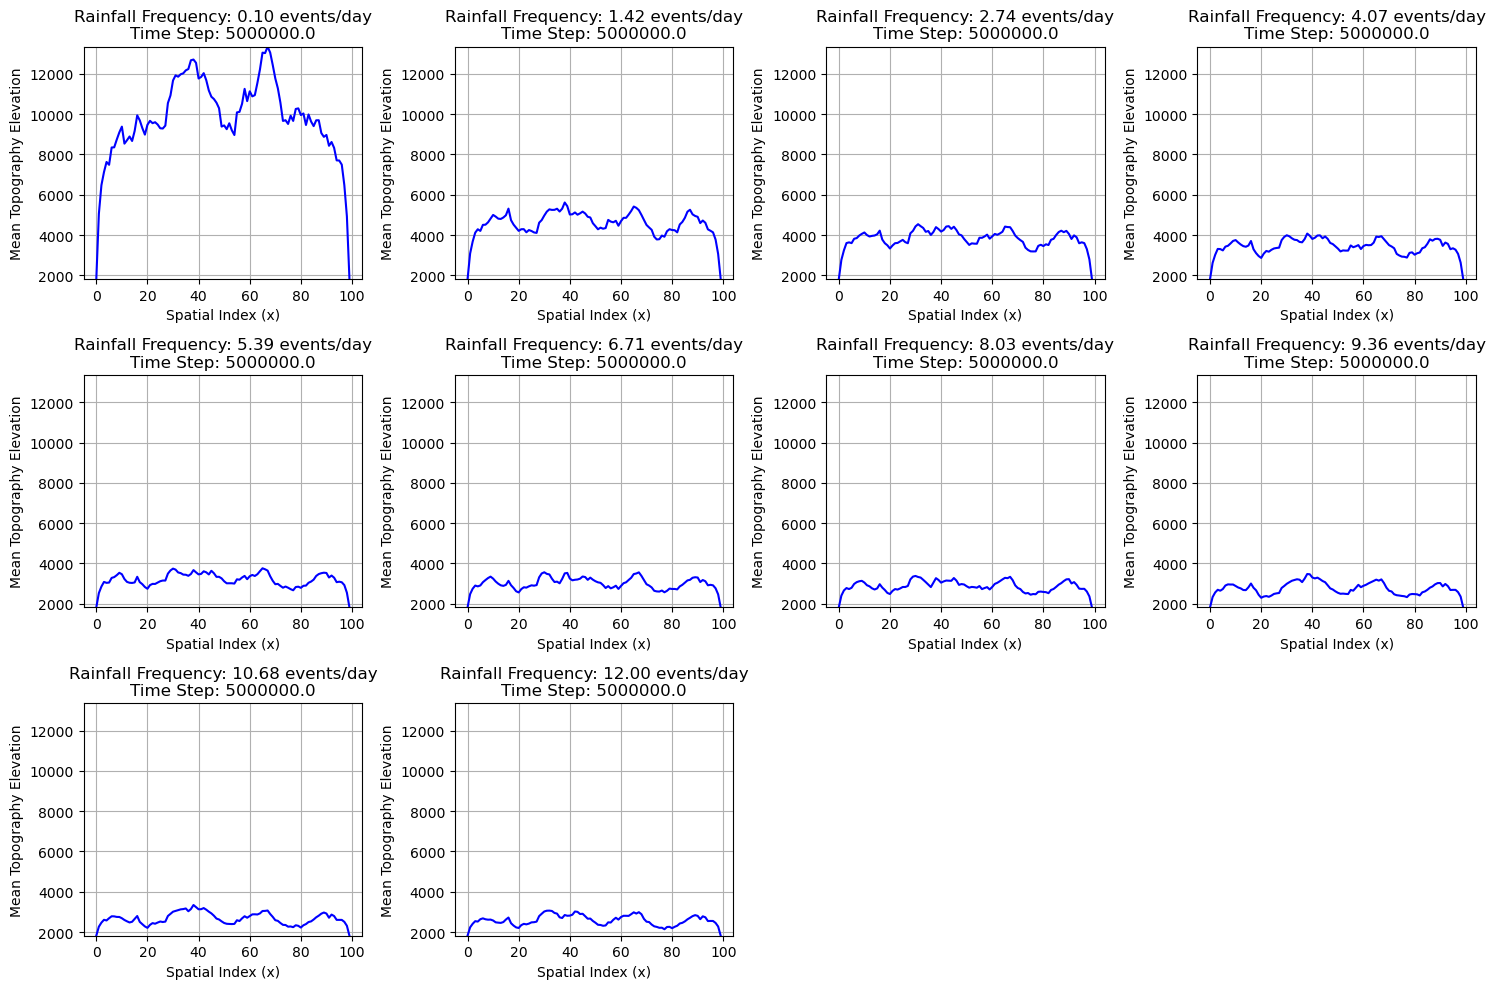

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency_") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract and sort rainfall frequency

# Define the rainfall frequency values to plot
desired_rainfall_frequencies = np.linspace(0.1, 12, 10)  # Ensure it matches simulation values

# Load datasets and attach rainfall frequency as a coordinate
datasets = []
rainfall_frequencies = []

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract rainfall frequency from filename
    ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
    
    # Add rainfall frequency as a coordinate
    ds = ds.assign_coords(rainfall_frequency=rainfall_frequency)
    
    datasets.append(ds)
    rainfall_frequencies.append(rainfall_frequency)

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")

# Ensure rainfall_frequency is a dimension and coordinate
combined_ds = combined_ds.sortby("rainfall_frequency")

# Print available values for debugging
print("Available rainfall frequencies in dataset:", combined_ds.rainfall_frequency.values)

# Fix: Use nearest selection for valid rainfall frequencies
valid_rainfall_frequencies = []
for rf in desired_rainfall_frequencies:
    try:
        # Use nearest method to avoid KeyError
        elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(rainfall_frequency=rf, method="nearest").mean(dim='x')
        valid_rainfall_frequencies.append(rf)
    except KeyError:
        print(f"Skipping {rf}: No matching data found.")

# Adjust number of rows and columns based on valid rainfall frequencies
n_valid = len(valid_rainfall_frequencies)
ncols = 4  # Define number of columns
nrows = (n_valid // ncols) + (1 if n_valid % ncols != 0 else 0)  # Calculate rows needed

# Create subplots dynamically based on valid rainfall frequencies
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten axes for easier indexing
axes = axes.flatten()

# Initialize variables to track the global min and max for consistent y-axis scaling
global_min_elevation = np.inf
global_max_elevation = -np.inf

# First, loop to find the global min and max of the mean topography elevations
for rf in valid_rainfall_frequencies:
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(rainfall_frequency=rf, method="nearest").mean(dim='x')
    global_min_elevation = min(global_min_elevation, elevation_data.min())
    global_max_elevation = max(global_max_elevation, elevation_data.max())

# Plot only for valid rainfall frequencies
for idx, rf in enumerate(valid_rainfall_frequencies):
    ax = axes[idx]
    time_step = str(combined_ds.time[-1].values)  # Extract the last time step value
    title = f"Rainfall Frequency: {rf:.2f} events/day\nTime Step: {time_step}"
    
    # Get the mean elevation for this rainfall frequency at the last time step
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(rainfall_frequency=rf, method="nearest").mean(dim='x')
    
    # Plot the elevation data as a line plot
    ax.plot(elevation_data, label='Mean Topography Elevation', color='blue')
    
    # Set title with rainfall frequency and time step info
    ax.set_title(title)
    
    # Set y-axis label
    ax.set_ylabel("Mean Topography Elevation")
    
    # Set x-axis label
    ax.set_xlabel("Spatial Index (x)")

    # Set consistent y-axis scale
    ax.set_ylim(global_min_elevation, global_max_elevation)
    
    # Add grid for readability
    ax.grid(True)

# Hide unused axes
for ax in axes[len(valid_rainfall_frequencies):]:
    ax.axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


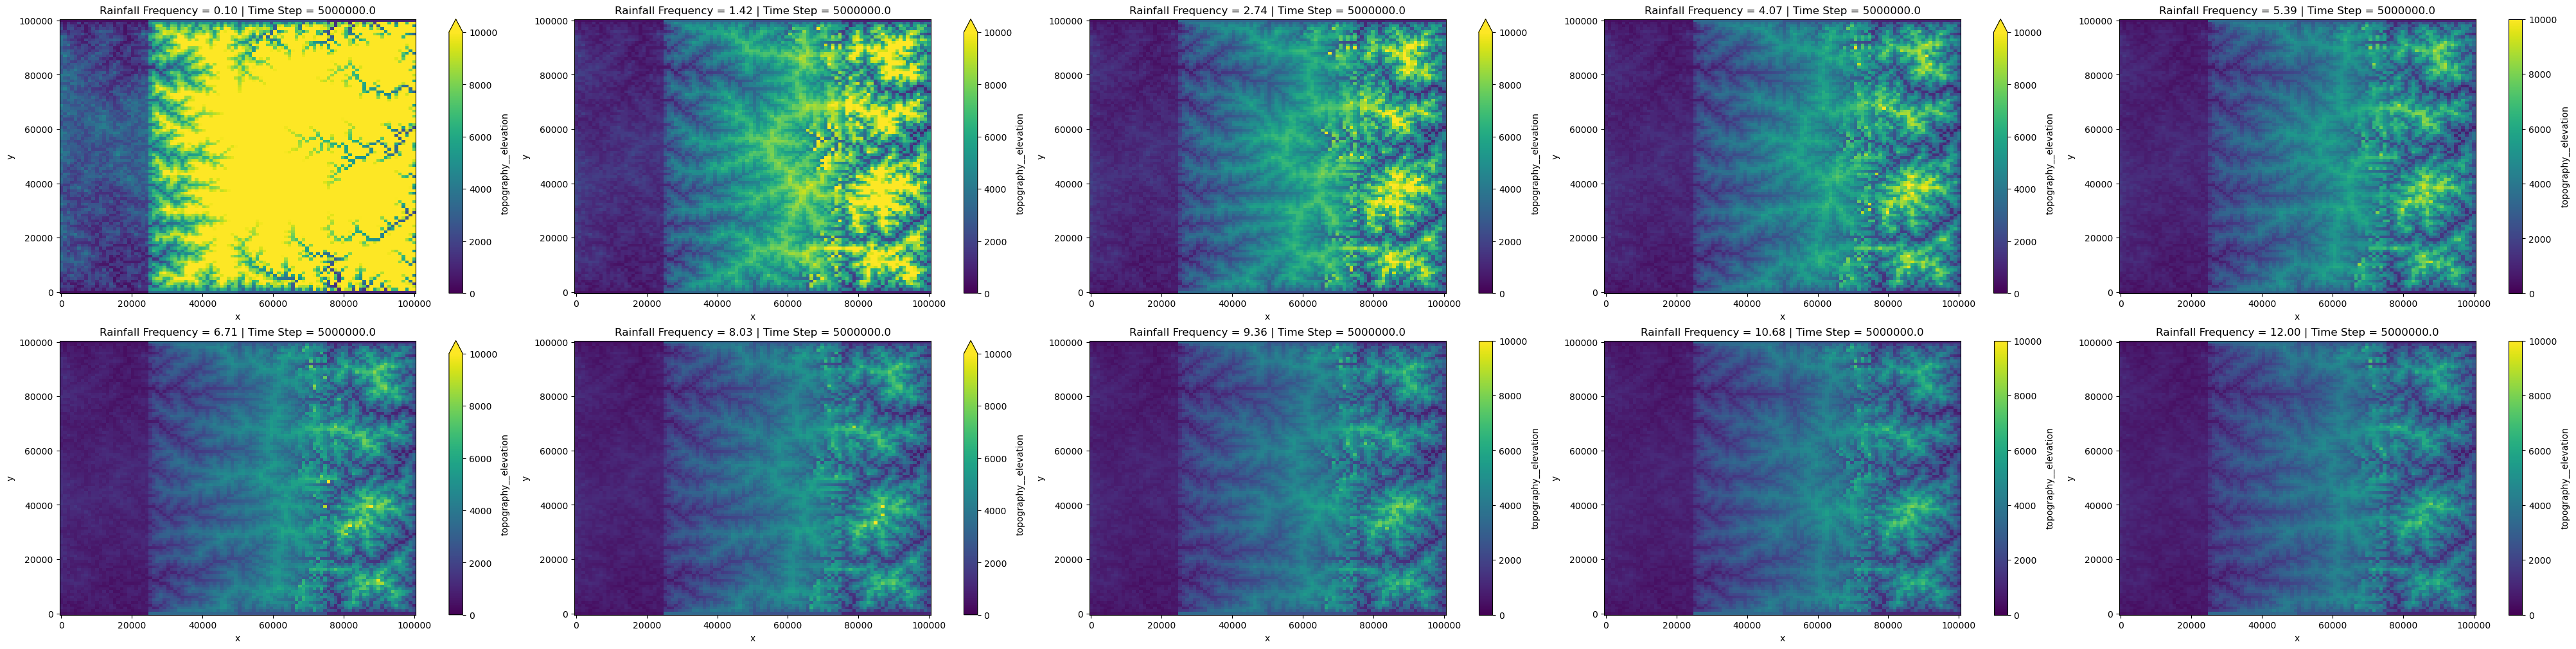

In [14]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract rainfall frequency from filename

# Define specific rainfall frequencies to plot
desired_rainfall_frequencies = [0.1, 1.42, 2.74, 4.07, 5.39, 6.71, 8.03, 9.36,10.68,12.]  # Adjust based on your simulations

# Load datasets and attach rainfall_frequency as a coordinate
datasets = []
rainfall_frequencies = []
time_steps = []

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if rainfall_frequency in desired_rainfall_frequencies:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add rainfall_frequency as a coordinate
        ds = ds.assign_coords(rainfall_frequency=rainfall_frequency)
        
        datasets.append(ds)
        rainfall_frequencies.append(rainfall_frequency)  # Append only desired values
        
        # Extract the last time step
        time_steps.append(ds.time.values[-1])

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")
combined_ds = combined_ds.sortby("rainfall_frequency")  # Ensure correct order

# Calculate grid layout for subplots
num_plots = len(rainfall_frequencies)
num_cols = (num_plots + 1) // 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# 📌 Plot: Elevation Maps for Selected Rainfall Frequencies at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, rainfall_frequency, time_step in zip(axes, datasets, rainfall_frequencies, time_steps):
    ds.topography__elevation.isel(time=-1).plot(ax=ax, vmin=0, vmax=10000, cmap='viridis')
    ax.set_title(f"Rainfall Frequency = {rainfall_frequency:.2f} | Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Hide any unused subplots
for i in range(len(rainfall_frequencies), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Elevation_RainfallFrequency_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


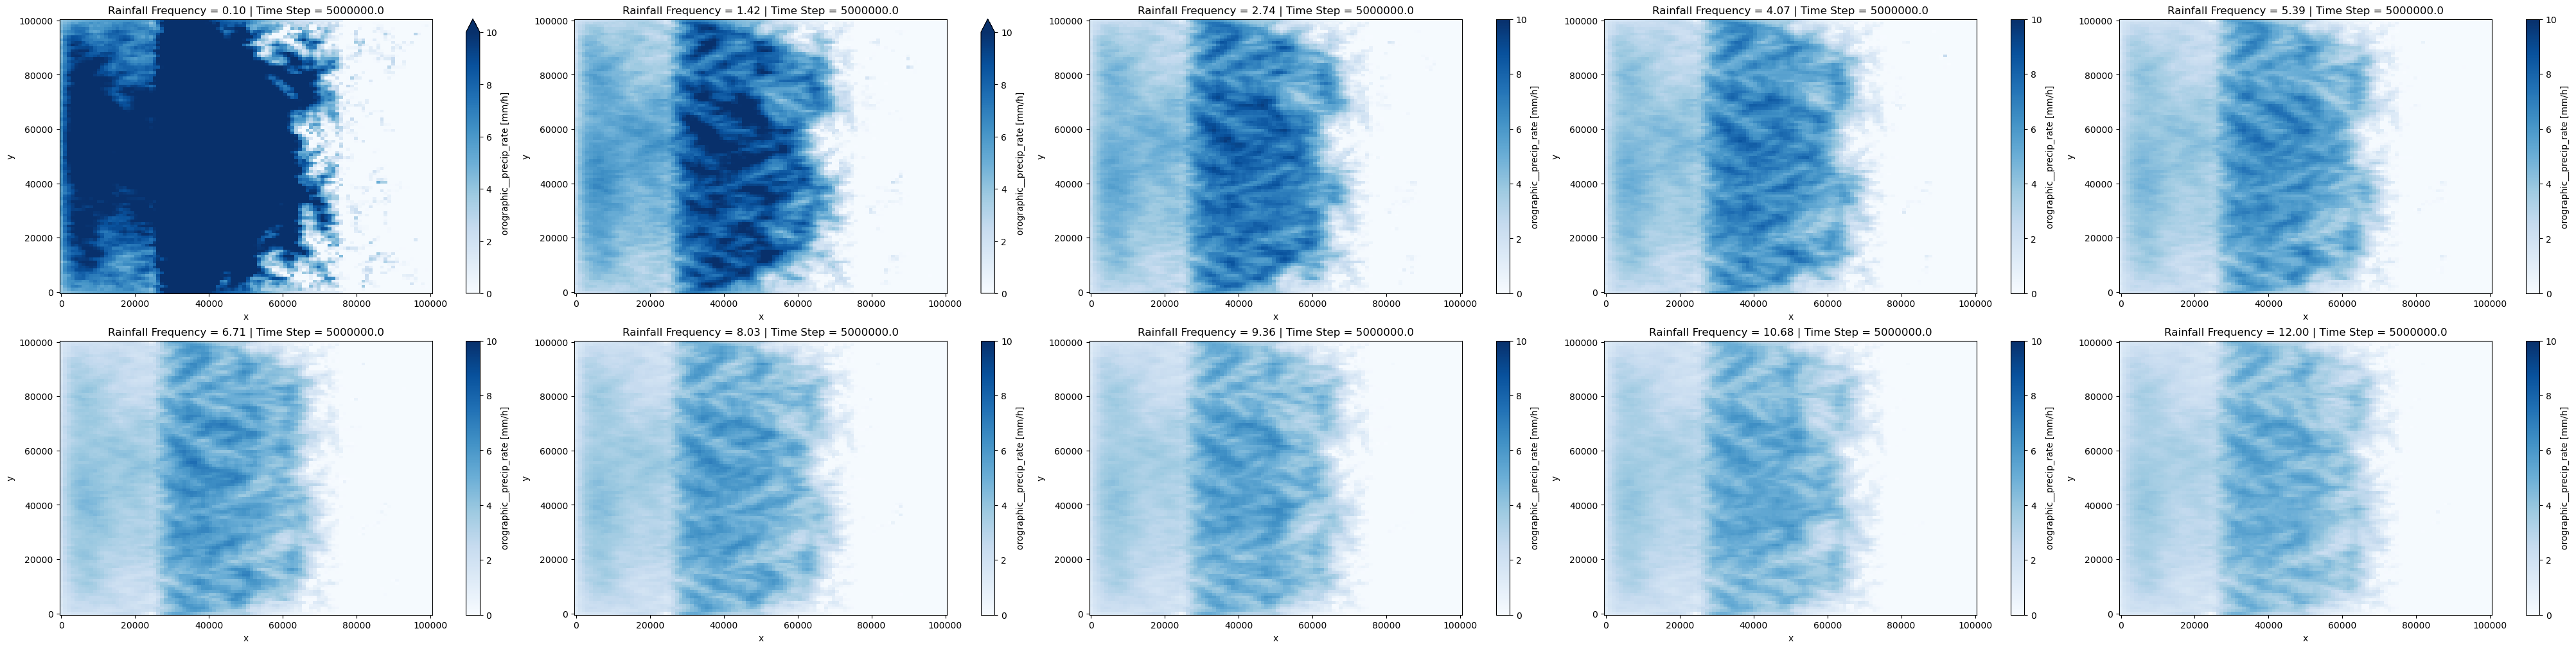

In [15]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract rainfall frequency

# Define specific rainfall frequencies to plot
desired_rainfall_frequencies = [0.1, 1.42, 2.74, 4.07, 5.39, 6.71, 8.03, 9.36,10.68,12.]  # Adjust based on your simulations

# Load datasets and attach rainfall_frequency as a coordinate
datasets = []
rainfall_frequencies = []
time_steps = []

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if rainfall_frequency in desired_rainfall_frequencies:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add rainfall_frequency as a coordinate
        ds = ds.assign_coords(rainfall_frequency=rainfall_frequency)
        
        datasets.append(ds)
        rainfall_frequencies.append(rainfall_frequency)  # Append only desired values
        
        # Extract the last time step
        time_steps.append(ds.time.values[-1])

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")
combined_ds = combined_ds.sortby("rainfall_frequency")  # Ensure correct order

# Calculate grid layout for subplots
num_plots = len(rainfall_frequencies)
num_cols = (num_plots + 1) // 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# 📌 Plot: Precipitation Maps for Selected Rainfall Frequencies at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, rainfall_frequency, time_step in zip(axes, datasets, rainfall_frequencies, time_steps):
    # Plot precipitation at the final time step
    precip_data = ds.orographic__precip_rate.isel(time=-1)
    precip_data.plot(ax=ax, vmin=0, vmax=10, cmap='Blues')
    ax.set_title(f"Rainfall Frequency = {rainfall_frequency:.2f} | Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Hide any unused subplots
for i in range(len(rainfall_frequencies), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Precipitation_RainfallFrequency_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


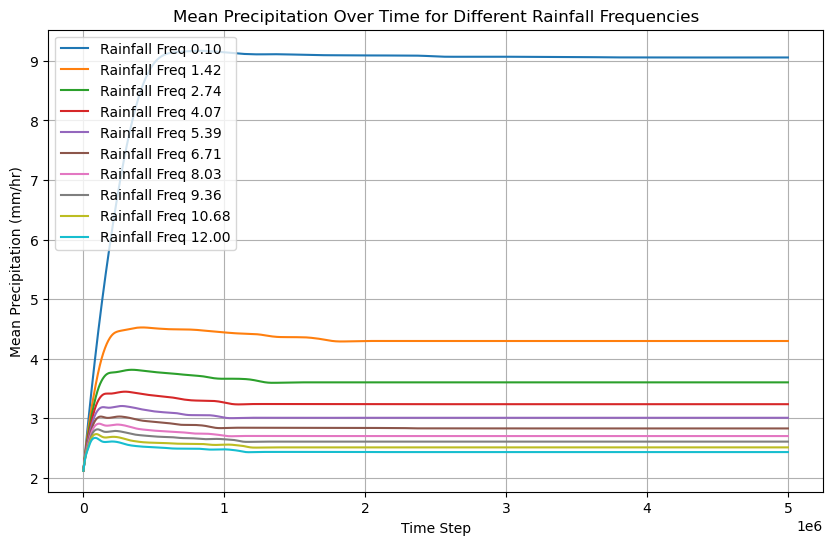

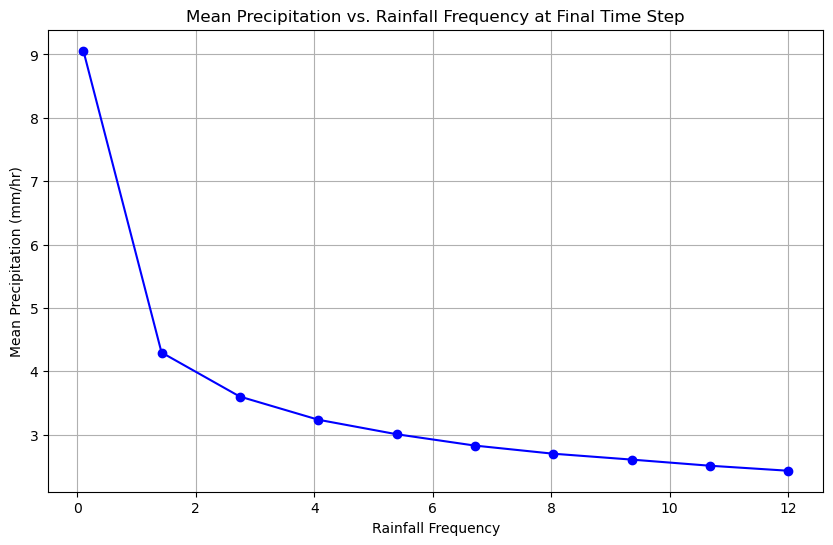

In [17]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract rainfall frequency

# Define specific rainfall frequencies to plot
desired_rainfall_frequencies = [0.1, 1.42, 2.74, 4.07, 5.39, 6.71, 8.03, 9.36,10.68,12.]  # Adjust based on your simulations

# Load datasets and attach rainfall_frequency as a coordinate
datasets = []
rainfall_frequencies = []

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if rainfall_frequency in desired_rainfall_frequencies:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add rainfall_frequency as a coordinate
        ds = ds.assign_coords(rainfall_frequency=rainfall_frequency)
        
        datasets.append(ds)
        rainfall_frequencies.append(rainfall_frequency)  # Append only desired values

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")
combined_ds = combined_ds.sortby("rainfall_frequency")  # Ensure correct order

### 📌 Plot 1: Mean Precipitation Over Time for Different Rainfall Frequencies
plt.figure(figsize=(10, 6))
for ds, rainfall_frequency in zip(datasets, rainfall_frequencies):
    mean_precip = ds["orographic__precip_rate"].mean(dim=("x", "y"))
    plt.plot(ds["time"], mean_precip, label=f"Rainfall Freq {rainfall_frequency:.2f}")

plt.xlabel("Time Step")
plt.ylabel("Mean Precipitation (mm/hr)")
plt.title("Mean Precipitation Over Time for Different Rainfall Frequencies")
plt.legend()
plt.grid()
plt.show()

### 📌 Plot 2: Mean Precipitation Across Rainfall Frequencies at Final Time Step
plt.figure(figsize=(10, 6))
mean_precip_final = combined_ds.orographic__precip_rate.isel(time=-1).mean(dim=("x", "y"))
plt.plot(rainfall_frequencies, mean_precip_final, marker="o", linestyle="-", color="b")
plt.xlabel("Rainfall Frequency")
plt.ylabel("Mean Precipitation (mm/hr)")
plt.title("Mean Precipitation vs. Rainfall Frequency at Final Time Step")
plt.grid()
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


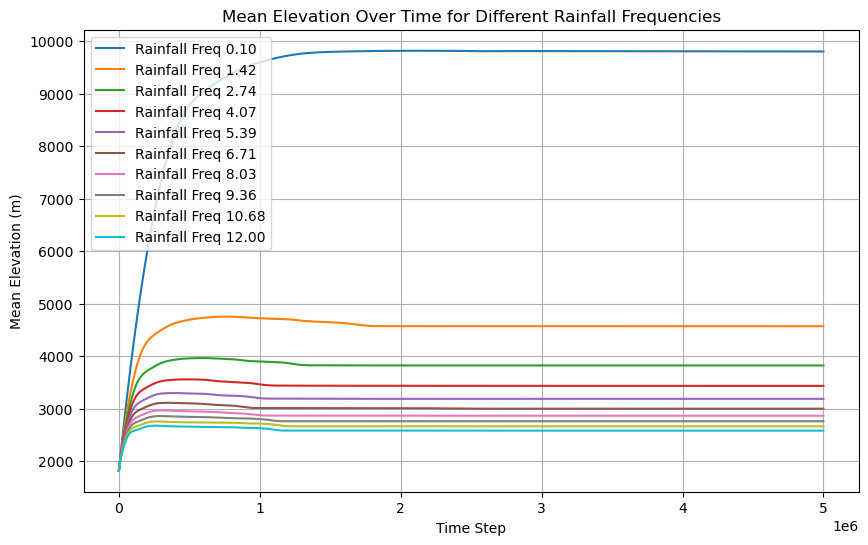

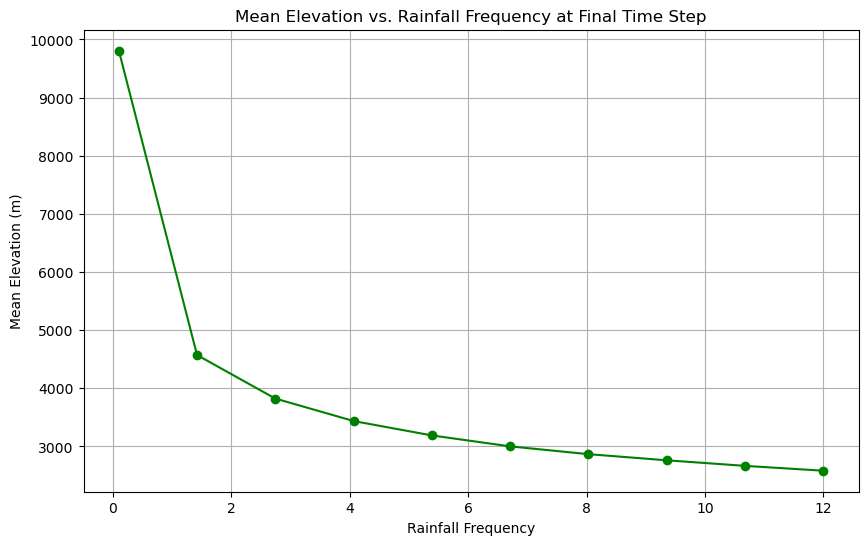

In [18]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by rainfall frequency
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_rainfall_frequency") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract rainfall frequency

# Define specific rainfall frequencies to plot
desired_rainfall_frequencies = [0.1, 1.42, 2.74, 4.07, 5.39, 6.71, 8.03, 9.36,10.68,12.] # Adjust based on your simulations

# Load datasets and attach rainfall_frequency as a coordinate
datasets = []
rainfall_frequencies = []

for zarr_file in zarr_files:
    rainfall_frequency = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if rainfall_frequency in desired_rainfall_frequencies:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add rainfall_frequency as a coordinate
        ds = ds.assign_coords(rainfall_frequency=rainfall_frequency)
        
        datasets.append(ds)
        rainfall_frequencies.append(rainfall_frequency)  # Append only desired values

# Concatenate datasets along the new rainfall_frequency dimension
combined_ds = xr.concat(datasets, dim="rainfall_frequency")
combined_ds = combined_ds.sortby("rainfall_frequency")  # Ensure correct order

### 📌 Plot 1: Mean Elevation Over Time for Different Rainfall Frequencies
plt.figure(figsize=(10, 6))
for ds, rainfall_frequency in zip(datasets, rainfall_frequencies):
    mean_elevation = ds["topography__elevation"].mean(dim=("x", "y"))
    plt.plot(ds["time"], mean_elevation, label=f"Rainfall Freq {rainfall_frequency:.2f}")

plt.xlabel("Time Step")
plt.ylabel("Mean Elevation (m)")
plt.title("Mean Elevation Over Time for Different Rainfall Frequencies")
plt.legend()
plt.grid()
plt.show()

### 📌 Plot 2: Mean Elevation Across Rainfall Frequencies at Final Time Step
plt.figure(figsize=(10, 6))
mean_elevation_final = combined_ds.topography__elevation.isel(time=-1).mean(dim=("x", "y"))
plt.plot(rainfall_frequencies, mean_elevation_final, marker="o", linestyle="-", color="g")
plt.xlabel("Rainfall Frequency")
plt.ylabel("Mean Elevation (m)")
plt.title("Mean Elevation vs. Rainfall Frequency at Final Time Step")
plt.grid()
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()
